In [14]:
import os, sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

from Weighted_VP_model import *
sys.path.append(os.path.abspath('../Weighted_VP_model'))
sys.path.append(os.path.abspath('../tensorflow_WHVP_model'))
from data_handling import *

from vpnet import *
from vpnet.vp_functions import *
from spike_classification import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker

import numpy as np
import matplotlib.pyplot as plt

from VPLayer import *
from XAIProject import *
import torch.nn.functional as F

In [2]:
model_name = 'trained_models/widnow_15_overlapping_11_hidden_6_nweight_4_id_6'
dtype = torch.float64
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
window_size_ = 15
overlapping_size_ = 11

dataSet = NeurographyDataset()
path = f'window_{window_size_}_overlap_{overlapping_size_}_corrected.pkl'
dataSet.load_samples_and_labels_from_file(path)

dataloaders = dataSet.sequential_split_with_resampling()

n_channels, n_in = dataSet.samples[0].shape
n_out = len(dataSet.binary_labels_onehot[0])
hidden1 = 6
weight_num = 4
affin = torch.tensor([6 / n_in, -0.3606]).tolist()
weight = ((torch.rand(weight_num)-0.5)*8).tolist()

model = VPNet(n_in, n_channels, hidden1, VPTypes.FEATURES, affin + weight, WeightedHermiteSystem(n_in, hidden1, weight_num), [hidden1], n_out, device=device, dtype=dtype)
model.load_state_dict(torch.load(model_name, weights_only=True))


c:\Users\darab\Documents\PROJECTS\VP_microneurography\code\data_handling.py:56: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_spike['track'] = all_spike['track'].replace(replacement_dict)


Dataloaders are ready.
LAYERS SIZE: [Flatten(start_dim=1, end_dim=-1), Linear(in_features=6, out_features=6, bias=True), ReLU(), Linear(in_features=6, out_features=2, bias=True), Softmax(dim=-1)]


<All keys matched successfully>

In [18]:
decision_boundary = 0.8
class_weights = torch.tensor([0.003, 0.997]).to(device)
weighted_criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
criterion = VPLoss(weighted_criterion, 0.1)
val_accuracy, val_loss, val_labels, val_predictions, val_probabilities = test(model, dataloaders['val_loader'], criterion, decision_boundary)
compute_metrics(val_labels, val_predictions)


Label 0:
  True Positives (TP): 0.0
  False Negatives (FN): 0.0
  False Positives (FP): 15258.0
  True Negatives (TN): 387548.0

Label 1:
  True Positives (TP): 259.0
  False Negatives (FN): 0.0
  False Positives (FP): 0.0
  True Negatives (TN): 0.0

Label 2:
  True Positives (TP): 255.0
  False Negatives (FN): 0.0
  False Positives (FP): 0.0
  True Negatives (TN): 0.0

Label 3:
  True Positives (TP): 236.0
  False Negatives (FN): 17.0
  False Positives (FP): 0.0
  True Negatives (TN): 0.0

Shape of all_multiple_labels: (403573,)


c:\Users\darab\Documents\PROJECTS\VP_microneurography\code\spike_classification.py:288: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


Val accuracy: 96.22%, loss: 10.2869
Weighted Balanced Accuracy: 0.9700
False Negative Indexes: [  5974 175600 175601 175602 175603 195602 209234 215236 235230 235231
 235233 285228 285229 325228 325229 325230 325231]
           MODEL METRICS          
Precision     : 0.0469
Recall        : 0.9778
F2-Score      : 0.1966
FPR           : 0.0379
       CONFUSION MATRIX           
              Predicted
          387548    15258
Actual    17    750
ROC-AUC       : 0.9700
MERGED METRICS
RECALL 0.9901477832512315
GROUND TRUTH POSITIVE
Overall length:  201
-----
Distinct length : count
3: 65
4: 108
5: 28
TRUE POSITIVE
Overall length:  201
-----
Distinct length : count
1: 4
2: 2
3: 3
4: 100
5: 27
6: 8
7: 53
8: 3
9: 1
FALSE POSITIVE
Overall length:  8455
-----
Distinct length : count
1: 5233
2: 1306
3: 735
4: 1017
5: 121
6: 28
7: 10
8: 3
9: 1
10: 1
FALSE NEGATIVE
Overall length:  2
-----
Distinct length : count
4: 2


In [3]:
val_all_samples = []
val_all_binary_labels = []
val_all_multiple_labels = []
for data in dataloaders['test_loader']:
    x, labels, multiple = data
    val_all_samples.append(x.cpu())
    val_all_binary_labels.append(labels.cpu())
    val_all_multiple_labels.append(multiple.cpu())
val_all_samples = torch.cat(val_all_samples).squeeze(1)
val_all_binary_labels = torch.cat(val_all_binary_labels)
val_all_multiple_labels = torch.cat(val_all_multiple_labels)
val_timestamps = dataloaders['test_timestamps']

In [83]:
val_all_samples.shape

torch.Size([403574, 15])

In [4]:
def reconstruct_original_sequence(overlapping_windows, window_size, overlapping):
    overlapping_windows = np.asarray(overlapping_windows)

    num_windows = len(overlapping_windows)
    stride = window_size - overlapping
    original_length = (num_windows - 1) * stride + window_size

    reconstructed_sequence = np.zeros(original_length)

    count_array = np.zeros(original_length)

    for i in range(num_windows):
        start_index = i * stride
        end_index = start_index + window_size
        
        reconstructed_sequence[start_index:end_index] += overlapping_windows[i]
        count_array[start_index:end_index] += 1

    non_zero_count_mask = count_array > 0
    reconstructed_sequence[non_zero_count_mask] /= count_array[non_zero_count_mask]

    reconstructed_sequence = np.nan_to_num(reconstructed_sequence)

    return reconstructed_sequence
original_val_samples = reconstruct_original_sequence(val_all_samples, 15, 11)
original_val_ts = reconstruct_original_sequence(val_timestamps, 15, 11)
original_val_samples.shape, original_val_ts.shape

((1614307,), (1614307,))

In [5]:
start_ts = original_val_ts[0]
end_ts = original_val_ts[-1]
df = dataSet.all_differentiated_spikes
start_index = dataSet.all_differentiated_spikes['ts'].searchsorted(start_ts, side='left')
end_index = dataSet.all_differentiated_spikes['ts'].searchsorted(end_ts, side='right')
val_gt_spikes = dataSet.all_differentiated_spikes.iloc[start_index:end_index]

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker

def plot_output_windows():

    val_timestamps_np = np.array(val_timestamps)
    len_orig_val = len(original_val_ts)
    val_probabilities_class1 = val_probabilities[:, 1]

    sample_size = 3000  # Number of datapoints to plot at a time

    """
    Create probability ranges.
    """
    custom_colors =  ['#808080', '#C0C0C0', 'khaki', '#FFA500', '#FF0000'] # Adjust colors as needed
    custom_colors =  ['#808080', '#C0C0C0', '#DBD48D', '#FFA500', '#FF0000'] # Adjust colors as needed
    bins = [0, 25, 50, 80, 98, 100]
    percentage_labels = ['0-25%', '25-50%', '50-80%', '80-98%', '98-100%']
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=label,
                            markerfacecolor=custom_colors[i], markersize=10) for i, label in enumerate(percentage_labels)]
    track_colors = { 1: 'black', 2: '#04BFAD', 3: 'green'}
    #track_colors = { 1: 'black', 2: 'cadetblue', 3: 'green'}

    #for start_index in range(21300, 21300+sample_size*3, sample_size):
    for start_index in range(181200, 181200+sample_size*3, sample_size):
        highest_probabilities = []
        end_index = start_index + sample_size
        for ts in original_val_ts[start_index:end_index]:
            window_mask = np.any((val_timestamps_np == ts), axis=1)
            window_indices = np.where(window_mask)[0]

            if window_indices.size > 0:
                probs = val_probabilities_class1[window_indices].numpy()
                highest_probability = np.mean(probs)
            else:
                highest_probability = np.nan

            highest_probabilities.append(highest_probability)

        df_orig = pd.DataFrame({
            'Timestamp': original_val_ts[start_index:end_index],
            'Samples': original_val_samples[start_index:end_index],
            'Probability': highest_probabilities
        })

        # Plotting
        plt.figure(figsize=(20, 6))

        # Define color bins based on val_probabilities_class1
        color_bins = np.digitize(df_orig['Probability'] * 100, bins=bins) - 1
        color_bins = np.clip(color_bins, 0, len(custom_colors) - 1)

        spike_labels = ['Stimulus', 'AP 1', 'AP 2']
        track_legend_elements = [Line2D([0], [0], color=track_colors[i + 1], lw=2, label=spike_labels[i]) for i in range(len(spike_labels))]

        # Scatter plot for this window
        plt.scatter(df_orig['Timestamp'],
                    df_orig['Samples'],
                    c=[custom_colors[color_bins[i]] for i in range(len(color_bins))],  # Color according to bins
                    alpha=0.6, s=10)

        # Add vertical lines based on DataFrame timestamps and track values
        window_timestamps = df_orig['Timestamp'].values
        print("Plotting range:", window_timestamps.min(), window_timestamps.max())
        filtered_df_val_range = val_gt_spikes[(val_gt_spikes['ts'] >= window_timestamps.min()) & 
                                        (val_gt_spikes['ts'] <= window_timestamps.max())]

        y_top = df_orig['Samples'].max() * 1.1  # Slightly above the max sample value
        y_bottom = df_orig['Samples'].min() * 1.1
        for index, row in filtered_df_val_range.iterrows():
            color = track_colors.get(int(row['track']), 'black')
            
            plt.scatter(row['ts'], y_top, color=color, s=120, alpha=0.8, edgecolor='black', linewidth=0.5)

            plt.scatter(row['ts'], y_bottom, color=color, s=120, alpha=0.8, edgecolor='black', linewidth=0.5)

            plt.axvline(x=row['ts'], color=track_colors[int(row['track'])], linestyle='--', lw=0.5)

        # Add legends
        plt.legend(handles=legend_elements + track_legend_elements, title="Probability and AP", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xlabel('Timestamp')
        plt.ylabel('Amplitude')
        plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(nbins=50))  # Increase the number of x-ticks
        plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:.4f}'))
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show(block=True)
        plt.close()
plot_output_windows()


Plotting range: 2503.807794082538 2504.107694082538
Plotting range: 2504.107794082538 2504.407694082538
Plotting range: 2504.4077940825377 2504.7076940825377


In [7]:
Phi, _ = model.vp_layer.fun_system(model.vp_layer.params)
Phip = torch.linalg.pinv(Phi, rtol=1e-15)

In [9]:
Phi.shape

torch.Size([6, 15])

In [ ]:
#3x2 plots

def dynamic_linewidth(x, x_min, x_max):
    center = (x_max + x_min) / 2
    width_factor = 1 - (abs(x - center) / (x_max - x_min))**0.8
    return 5 * width_factor


hermite_tensor = Phi.cpu().detach().numpy()
)
x_values = np.linspace(-5, 5, 15)

fig, axes = plt.subplots(3, 2, figsize=(10, 12))

axes = axes.flatten()

for i in range(6):
    y_values = hermite_tensor[i]
    
    for j in range(len(x_values) - 1):
        linewidth = dynamic_linewidth(x_values[j], x_values[0], x_values[-1])
        
        axes[i].plot(x_values[j:j+2], y_values[j:j+2], label=f'Hermite Basis {i+1}' if j == 0 else "", 
                     color=plt.cm.viridis(i / 6), linewidth=linewidth)
    axes[i].set_title(f'Hermite Basis Function {i+1}')
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')
    axes[i].grid(axis='y')
    axes[i].legend()

    if i in [0, 1, 3, 4]:
        axes[i].spines['top'].set_linewidth(2)
        axes[i].spines['top'].set_edgecolor('red')
        axes[i].spines['right'].set_linewidth(2)
        axes[i].spines['right'].set_edgecolor('red')
        axes[i].spines['bottom'].set_linewidth(2)
        axes[i].spines['bottom'].set_edgecolor('red')
        axes[i].spines['left'].set_linewidth(2)
        axes[i].spines['left'].set_edgecolor('red')

plt.tight_layout()
plt.show()

In [10]:
# plot one by one
 
hermite_tensor = Phi.cpu().detach().numpy()  # Convert to NumPy array

x_values = np.linspace(-5, 5, 15) 

def dynamic_linewidth(x, x_min, x_max):
    center = (x_max + x_min) / 2
    width_factor = 1 - (abs(x - center) / (x_max - x_min))**2
    return 6 * width_factor


for i in range(6):
    plt.figure(figsize=(5,5)
    y_values = hermite_tensor[i]
    color_value = (i + 1) / 7 
    
    color = plt.cm.viridis(0.25 + color_value * 0.5)
    
    for j in range(len(x_values) - 1):
        linewidth = dynamic_linewidth(x_values[j], x_values[0], x_values[-1])
        
        plt.plot(x_values[j:j+2], y_values[j:j+2], label=f'Hermite Basis {i+1}' if j == 0 else "", 
                     color=color, linewidth=linewidth)

    plt.title(f'Hermite Basis Function {i+1}')
    plt.grid(axis='y')

    # Set a thick orange border for the first, second, fourth, and fifth subplots
    if i in [0, 1, 3, 4]:
        plt.gca().spines['top'].set_linewidth(2)
        plt.gca().spines['top'].set_edgecolor('red')
        plt.gca().spines['right'].set_linewidth(2)
        plt.gca().spines['right'].set_edgecolor('red')
        plt.gca().spines['bottom'].set_linewidth(2)
        plt.gca().spines['bottom'].set_edgecolor('red')
        plt.gca().spines['left'].set_linewidth(2)
        plt.gca().spines['left'].set_edgecolor('red')

    plt.tight_layout()

    plt.show()
    plt.close()

In [11]:
val_all_samples = val_all_samples.to(device)
vplayer_output = val_all_samples @ Phip
vplayer_output.shape

torch.Size([403574, 6])

In [12]:
# plot the feature values
data_flat = vplayer_output[0].detach().cpu().flatten().numpy()

bar_width = 0.8
x_positions = range(len(data_flat))
plt.grid(True)
plt.bar(x_positions, data_flat, width=bar_width, color='teal', edgecolor='black')

# Add a horizontal line at zero
plt.axhline(0, color='black', linewidth=1.2, linestyle='--')
plt.grid(True, linestyle='--', alpha=0.6, zorder=1)
plt.xticks(x_positions)

plt.tight_layout()
plt.show()

In [103]:
def create_tf_fully_connected():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(6,)),
        tf.keras.layers.Dense(6, activation ='relu', use_bias=True),
        #tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(2, activation = 'softmax', use_bias=True),
        #tf.keras.layers.Softmax()
    ])
    return model

In [63]:
torch_weights = torch.load(model_name, weights_only=True)
weights_fc1 = torch_weights['fcnn.1.weight'].cpu().numpy()
biases_fc1 = torch_weights['fcnn.1.bias'].cpu().numpy()

weights_fc2 = torch_weights['fcnn.3.weight'].cpu().numpy()
biases_fc2 = torch_weights['fcnn.3.bias'].cpu().numpy() 

weights_fc1_tf = np.transpose(weights_fc1)
weights_fc2_tf = np.transpose(weights_fc2)

In [105]:
tf_fully_connected_model = create_tf_fully_connected()

tf_fully_connected_model.layers[0].set_weights([weights_fc1_tf, biases_fc1])
tf_fully_connected_model.layers[1].set_weights([weights_fc2_tf, biases_fc2])
tf_fully_connected_model.compile(optimizer='adam', 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

In [19]:
tf_fully_connected_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6)                 42        
                                                                 
 re_lu_1 (ReLU)              (None, 6)                 0         
                                                                 
 dense_3 (Dense)             (None, 2)                 14        
                                                                 
Total params: 56 (224.00 Byte)
Trainable params: 56 (224.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
def convert_to_class_labels(predictions):
    class_labels = (predictions[:, 1] >= decision_boundary).astype(int)
    #class_labels = np.argmax(predictions, axis=1)
    return class_labels

input_data_vp_output = vplayer_output

with torch.no_grad():
    pytorch_output_fc = model.fcnn(input_data_vp_output).cpu().numpy() 
pytorch_labels_fc = convert_to_class_labels(pytorch_output_fc)

print("PyTorch output:\n", pytorch_labels_fc[:10])

tf_input_data_vp_output = input_data_vp_output.cpu().detach().numpy().astype(np.float32)
tf_output_fc = tf_fully_connected_model.predict(tf_input_data_vp_output)
tf_labels_fc = convert_to_class_labels(tf_output_fc)

print("TensorFlow output:\n", tf_labels_fc[:10])

correct_predictions = np.sum(pytorch_labels_fc == tf_labels_fc)
total_predictions = len(pytorch_labels_fc)

accuracy = correct_predictions / total_predictions
print(f'Accuracy: {accuracy:.4f}')

1.2828681368575305e-28 1.0
PyTorch output:
 [0 0 0 0 0 0 0 0 0 0]
1.2828712e-28 1.0
TensorFlow output:
 [0 0 0 0 0 0 0 0 0 0]
Accuracy: 1.0000


In [110]:
import tensorflow as tf

HNUM = 6
VP_INIT = [1.0, -6.0]
WEIGHTS = np.random.uniform(-7, 2, weight_num)
VP_INIT.extend(list(WEIGHTS))
VP_PEN = 0.1
torch_weights = torch.load(model_name, weights_only=True)

def create_tf_WHVPNet():
  keras_model = tf.keras.Sequential()
  keras_model.add(tf.keras.Input(shape=15))
  keras_model.add(VPLayer(15, HNUM, VP_INIT, VP_PEN, name='vplayer'))
  keras_model.add(tf.keras.layers.Dense(6, activation='relu', name='linear1'))
  keras_model.add(tf.keras.layers.Dense(2, activation='softmax', name='linear2'))

  keras_model.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

  return keras_model

tf_WHVPNet_model = create_tf_WHVPNet()



In [111]:
weights_vp = torch_weights['vp_layer.params'].cpu().numpy()

weights_fc1 = torch_weights['fcnn.1.weight'].cpu().numpy()
biases_fc1 = torch_weights['fcnn.1.bias'].cpu().numpy()

weights_fc2 = torch_weights['fcnn.3.weight'].cpu().numpy()
biases_fc2 = torch_weights['fcnn.3.bias'].cpu().numpy() 

weights_fc1_tf = np.transpose(weights_fc1)
weights_fc2_tf = np.transpose(weights_fc2)

In [112]:

num_weights = 6
weight_splits = np.split(weights_vp, num_weights)
tf_WHVPNet_model.layers[0].set_weights(weight_splits)
tf_WHVPNet_model.layers[1].set_weights([weights_fc1_tf, biases_fc1])
tf_WHVPNet_model.layers[2].set_weights([weights_fc2_tf, biases_fc2])
tf_WHVPNet_model.compile(optimizer='adam', 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

In [113]:
for layer in tf_WHVPNet_model.layers:
    layer_name = layer.name
    print(f"Layer: {layer_name}")
    weights = layer.get_weights()
    for weight in weights:
        print(weight)

Layer: vplayer
[0.29458204]
[-0.1223308]
[0.11282437]
[2.034438]
[-2.4693894]
[-2.4352572]
Layer: linear1
[[ 2.3768773   0.03304804 -0.5201561  -3.1334753   0.13251445  0.50877136]
 [-1.1455201   0.97150946 -0.7078586  -0.48276868 -0.23640159  0.6311314 ]
 [ 0.49147156 -0.5368033  -0.37027687  0.7426802  -0.61502874  0.7837017 ]
 [-0.9831456  -0.29419735  0.10253707  0.18991917  1.9077662   0.27465516]
 [ 0.99615663  0.06414719 -0.9037405   0.1109243  -2.4078267   0.39227232]
 [-0.5289753   1.3333359  -0.694927   -2.527189   -0.56070113 -1.1526153 ]]
[-0.4631518   1.8874186  -0.56024146 -0.88515073 -0.4086451  -1.7952754 ]
Layer: linear2
[[-2.2695105   2.0327873 ]
 [ 2.0888305  -2.1858885 ]
 [-0.39287362  0.70710963]
 [-2.56295     2.157705  ]
 [-3.4237921   3.0504346 ]
 [-1.2937528   1.6473842 ]]
[ 1.0751281 -1.0423357]


In [114]:
for layer_name, weights in torch_weights.items():
    print(f"Layer: {layer_name}")
    print(weights.cpu().numpy()) 

Layer: vp_layer.params
[ 0.29458203 -0.1223308   0.11282437  2.0344379  -2.46938941 -2.43525714]
Layer: fcnn.1.weight
[[ 2.37687736 -1.14552004  0.49147157 -0.98314559  0.99615662 -0.52897529]
 [ 0.03304804  0.97150944 -0.53680331 -0.29419734  0.06414719  1.33333587]
 [-0.5201561  -0.70785864 -0.37027686  0.10253708 -0.90374054 -0.69492697]
 [-3.13347536 -0.48276868  0.7426802   0.18991918  0.1109243  -2.52718904]
 [ 0.13251444 -0.23640159 -0.61502873  1.90776625 -2.40782658 -0.56070111]
 [ 0.50877135  0.63113139  0.78370171  0.27465515  0.39227231 -1.15261536]]
Layer: fcnn.1.bias
[-0.46315182  1.8874186  -0.56024145 -0.88515075 -0.40864509 -1.79527545]
Layer: fcnn.3.weight
[[-2.26951053  2.08883037 -0.39287361 -2.56294982 -3.42379221 -1.29375282]
 [ 2.03278731 -2.18588841  0.70710961  2.15770502  3.05043449  1.64738419]]
Layer: fcnn.3.bias
[ 1.07512809 -1.04233571]


In [115]:
input_data = val_all_samples

with torch.no_grad():
    pytorch_output_fc = model(input_data)[0].cpu().numpy() 

pytorch_labels_fc = convert_to_class_labels(pytorch_output_fc)

print("PyTorch output:\n", pytorch_labels_fc[:10])

tf_input_data = input_data.cpu().detach().numpy().astype(np.float64)
keras_output = tf_WHVPNet_model.predict(tf_input_data)
tf_labels_fc = convert_to_class_labels(keras_output)

print("TensorFlow output:\n", tf_labels_fc[:10])

correct_predictions = np.sum(pytorch_labels_fc == tf_labels_fc)
total_predictions = len(pytorch_labels_fc)

accuracy = correct_predictions / total_predictions
print(f'Accuracy: {accuracy:.4f}')

PyTorch output:
 [0 0 0 0 0 0 0 0 0 0]


c:\Users\darab\anaconda3\envs\microneurography\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


TensorFlow output:
 [0 0 0 0 0 0 0 0 0 0]
Accuracy: 0.9774


In [116]:
same_indices = np.where(tf_labels_fc == pytorch_labels_fc)[0]

In [106]:
import innvestigate
tf_fully_connected_model_ = innvestigate.model_wo_softmax(tf_fully_connected_model)
integrated_gradient_analyzer_fe = innvestigate.create_analyzer("integrated_gradients", tf_fully_connected_model_, neuron_selection_mode="max_activation",reference_inputs=0, steps = 64)
analyzation_fe = integrated_gradient_analyzer_fe.analyze(tf_input_data_vp_output)

c:\Users\darab\anaconda3\envs\microneurography\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [118]:
tf_WHVPNet_model_ = innvestigate.model_wo_softmax(tf_WHVPNet_model)
integrated_gradient_analyzer_full = innvestigate.create_analyzer("integrated_gradients", tf_WHVPNet_model_, neuron_selection_mode="max_activation",reference_inputs=0, steps = 64)
analyzation_full = integrated_gradient_analyzer_full.analyze(tf_input_data)

c:\Users\darab\anaconda3\envs\microneurography\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [74]:
val_all_binary_labels_np = val_all_binary_labels.numpy()
val_all_multiple_labels_np = val_all_multiple_labels.numpy()

In [119]:
feature_extractor_XAIProject = XAIProject(model=tf_fully_connected_model,
                                          samples=tf_input_data_vp_output,
                                          binary_labels=val_all_binary_labels_np,
                                          multiple_labels=val_all_multiple_labels_np,
                                          probabilities=tf_output_fc)
feature_extractor_XAIProject.analyzer_output = analyzation_fe

In [76]:
full_extractor_XAIProject = XAIProject(model=tf_WHVPNet_model,
                                          samples=tf_input_data,
                                          binary_labels=val_all_binary_labels_np,
                                          multiple_labels=val_all_multiple_labels_np,
                                          probabilities=keras_output)
full_extractor_XAIProject.analyzer_output = analyzation_full

In [ ]:
"""
print the original input data
"""
class_0_indices = full_extractor_XAIProject.get_truth_class_binary_indices_for_class(0)
class_1_indices = full_extractor_XAIProject.get_truth_class_multiple_indices_for_class(3)
inputs_class_0 = full_extractor_XAIProject.samples[class_0_indices[::10000]]
inputs_class_1 = full_extractor_XAIProject.samples[class_1_indices[::50]]

fig, ax = plt.subplots(figsize=(12, 6))

for row in inputs_class_1:
    ax.plot(row, color="lime", linestyle="--", linewidth = 1, label = "Class 1")
for row in inputs_class_0:
    ax.plot(row, color="red", linestyle="--", linewidth = 1,  label = "Class 0")

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())
ax.set_xlabel("Time (s)")
ax.set_ylabel("Voltage (mV)")
plt.show()

In [67]:
import random
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches

def create_comparison_plot(project : XAIProject, binary_class_num, multiple_class_num, prediction_quality, random_, average_sample, average_analyzer):
    """
    project: BinaryProject() instance that holds the analyzation

    class_num: the id of the class which should be shown on the plots

    prediction_quality: correct, incorrect, false_negative or false_positive in string format
    
    random_: boolean that shows if randomized single inputs should be shown on the plot
    
    average_sample: boolean that shows if the averaged original recording should be shown on the plot
    
    average_analyzer: boolean that shows if the averaged relevance scores shoul be shown on the plot

    """
    if prediction_quality == "correct": #
        if binary_class_num == 1 and multiple_class_num:
            indices_for_class = project.get_true_positive_indices_for_multiple_class(multiple_class_num)
            title = f"True positive predictions for multi-class {multiple_class_num}"
        elif binary_class_num == 1 and not multiple_class_num:
            indices_for_class = project.get_true_pos_prediction_indices()
            title = f"True positive predictions"
        elif binary_class_num == 0 and not multiple_class_num:
            indices_for_class = project.get_ture_neg_prediction_indices()
            title = f"True negative predictions"
    elif prediction_quality == "incorrect":
        indices_for_class = project.get_incorrect_prediction_indices_for_class(binary_class_num)
        title = f"Incorrect predictions for class {binary_class_num}"
    elif prediction_quality == "false_negative": #
        if binary_class_num == 1 and multiple_class_num:
            indices_for_class = project.get_false_negative_indices_for_multiple_class(multiple_class_num)
            title = f"False negative predictions for multi-class {multiple_class_num}"
        else:
            indices_for_class = project.get_false_negative_indices()
            title = f"False negative predictions"
        
    elif prediction_quality == "false_positive":
        indices_for_class = project.get_false_positive_indices()
        title = "False positive predictions"

    filtered_indices_for_class = np.intersect1d(indices_for_class, same_indices)
    input_for_class = project.samples[filtered_indices_for_class]
    analyzer_for_class = project.analyzer_output[filtered_indices_for_class]
    
    # input_for_class = project.samples[indices_for_class]
    # analyzer_for_class = project.analyzer_output[indices_for_class]


    analyzer_class_mean = np.mean(analyzer_for_class, axis=0, keepdims=True)
    input_class_mean = np.mean(input_for_class, axis=0, keepdims=True)

    if input_for_class.shape[0] == 0:
        return
    if random_ == True:
        random_indice_to_plot = random.sample(range(input_for_class.shape[0]), 1)[0]

    blue = (0 / 255, 139 / 255, 139 / 255)
    red = (139 / 255, 0 / 255, 0 / 255)
    num_steps = 256
    colors = [blue, (0.82745, 0.82745, 0.82745) ,red]

    custom_cmap = LinearSegmentedColormap.from_list("custom_colormap", colors, N=num_steps)

    fig = plt.figure(figsize=(8,4))

    ax = fig.add_subplot(111)
    avg_re = avg_an = single_legend = None
    if binary_class_num == 0:
        c = blue
    else:
        c = red
    if average_sample == True:
        #y = upsample(normalize(input_class_mean[0,:], -1, 1),5)
        y = upsample(input_class_mean[0,:],3)
        x = range(len(y))
        ax.scatter(x, y, color=c, label="Input mean", s=10)
        avg_re = plt.Line2D([0], [0], color=c, linewidth=3, label='Recording mean')
    if average_analyzer == True:
        #y = upsample(normalize(analyzer_class_mean[0,:], -1, 1),5)
        y = upsample(analyzer_class_mean[0,:],3)
        x = range(len(y))
        ax.scatter(x, y, color="dimgray", label="Analyzer mean", s=10)
        avg_an = plt.Line2D([0], [0], color="dimgray", linewidth=3, label='Analyzer mean')
    if random_ == True:
        #color_base = upsample(normalize(analyzer_for_class[random_indice_to_plot,:], -1, 1),5)
        #y = upsample(normalize(input_for_class[random_indice_to_plot,:], -1, 1), 5)
        color_base = upsample(analyzer_for_class[random_indice_to_plot,:],3)
        y = upsample(input_for_class[random_indice_to_plot,:], 3)
        x = range(len(y))
        cmap = plt.get_cmap(custom_cmap)
        norm = plt.Normalize(-1, 1)
        line_colors = cmap(norm(color_base))
        ax.scatter(x, y, color=line_colors, label="Single input", s=20)
        sm = ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax)
        cbar.set_label('Analyzer value')
        single_legend = plt.Line2D([0], [0], color=blue, linewidth=4, label='Single recording')

    ax.set_xlim([0, len(y)])
    current_ticks = ax.get_xticks()
    adjusted_labels = current_ticks / 5
    ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])

    # for h_line in np.arange(-1,1.25,0.5):
    #     ax.axhline(y = h_line, color = "gray", linestyle = "dashed", linewidth = 0.25)

    # extra rectangle
    rect = patches.Rectangle((500, -1), 1500, 2, linewidth=1, edgecolor='orange', facecolor='none')
    ax.add_patch(rect)

    handle = [line for line in [avg_re, avg_an, single_legend] if line is not None]
    ax.legend(handles=handle, fontsize=11)
    #ax.set_yticks(np.arange(-1, 1.25, 0.25))
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Time", fontsize=12)
    ax.set_ylabel("Amplitude", fontsize=12)
    fig.tight_layout()

C:\Users\darab\AppData\Local\Temp\ipykernel_4536\389779.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])
C:\Users\darab\AppData\Local\Temp\ipykernel_4536\389779.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])
C:\Users\darab\AppData\Local\Temp\ipykernel_4536\389779.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])
C:\Users\darab\AppData\Local\Temp\ipykernel_4536\389779.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{

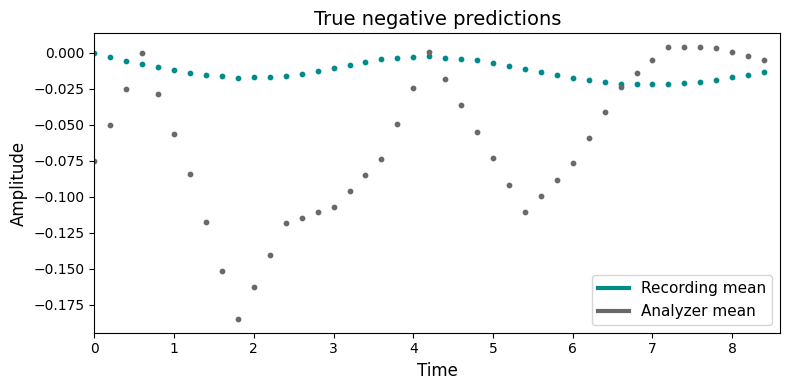

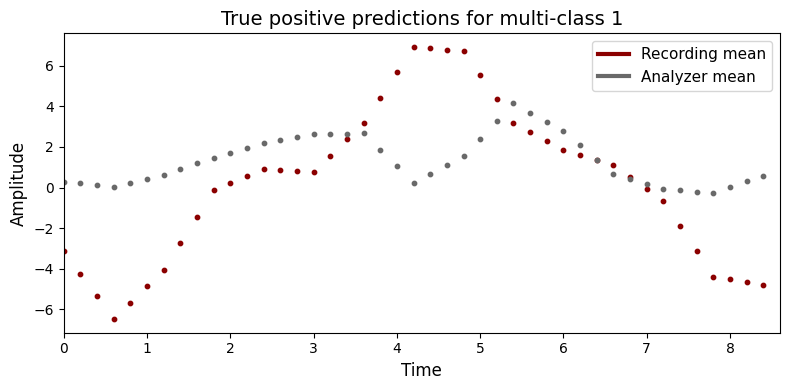

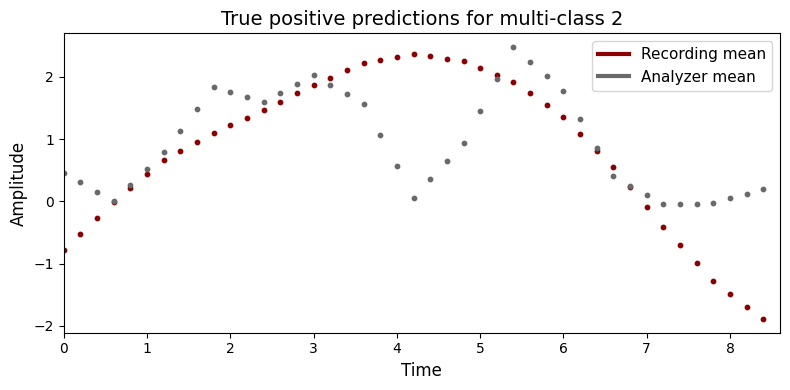

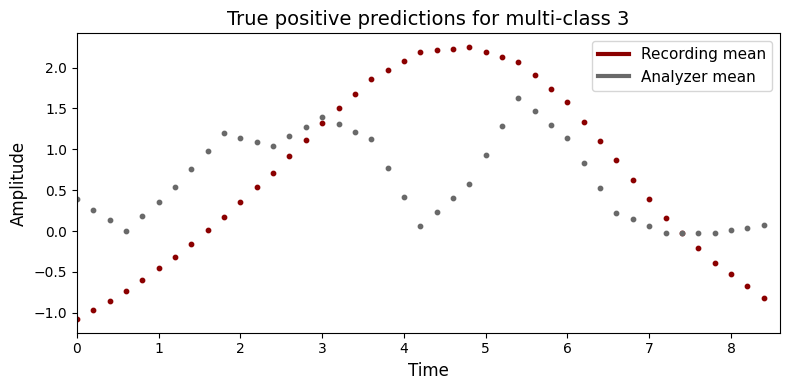

In [68]:
create_comparison_plot(full_extractor_XAIProject, binary_class_num = 0, multiple_class_num=False, prediction_quality = "correct", random_ = False, average_sample = True, average_analyzer = True)
create_comparison_plot(full_extractor_XAIProject, binary_class_num = 1, multiple_class_num=1, prediction_quality = "correct", random_ = False, average_sample = True, average_analyzer = True)
create_comparison_plot(full_extractor_XAIProject, binary_class_num = 1, multiple_class_num=2, prediction_quality = "correct", random_ = False, average_sample = True, average_analyzer = True)
create_comparison_plot(full_extractor_XAIProject, binary_class_num = 1, multiple_class_num=3, prediction_quality = "correct", random_ = False, average_sample = True, average_analyzer = True)

C:\Users\darab\AppData\Local\Temp\ipykernel_4536\389779.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])
C:\Users\darab\AppData\Local\Temp\ipykernel_4536\389779.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])


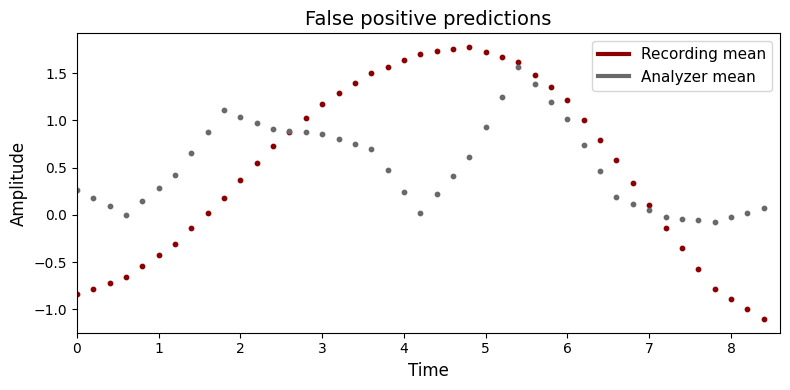

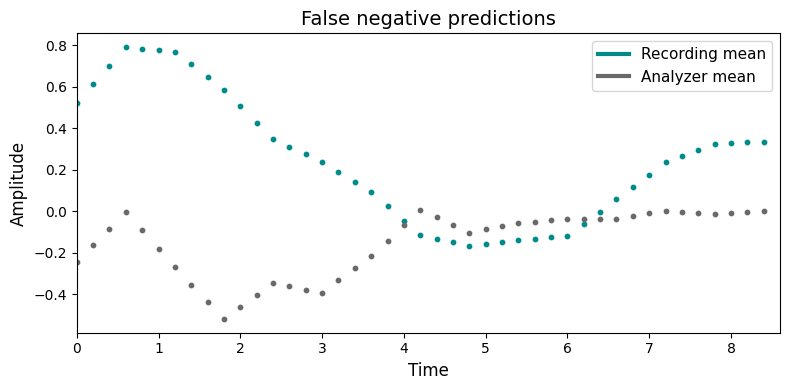

In [69]:

create_comparison_plot(full_extractor_XAIProject, binary_class_num = 1, multiple_class_num=False, prediction_quality = "false_positive", random_ = False, average_sample = True, average_analyzer = True)
create_comparison_plot(full_extractor_XAIProject, binary_class_num = 0, multiple_class_num=False, prediction_quality = "false_negative", random_ = False, average_sample = True, average_analyzer = True)

c:\Users\darab\anaconda3\envs\microneurography\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\darab\anaconda3\envs\microneurography\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\darab\AppData\Local\Temp\ipykernel_4536\389779.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])


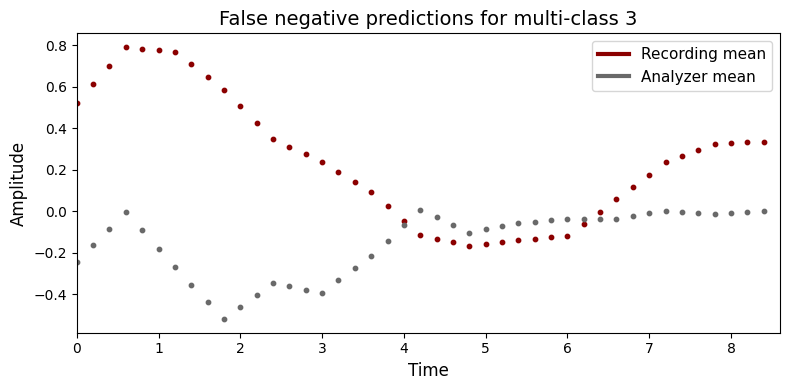

In [70]:
create_comparison_plot(full_extractor_XAIProject, binary_class_num = 1, multiple_class_num=1, prediction_quality = "false_negative", random_ = False, average_sample = True, average_analyzer = True)
create_comparison_plot(full_extractor_XAIProject, binary_class_num = 1, multiple_class_num=2, prediction_quality = "false_negative", random_ = False, average_sample = True, average_analyzer = True)
create_comparison_plot(full_extractor_XAIProject, binary_class_num = 1, multiple_class_num=3, prediction_quality = "false_negative", random_ = False, average_sample = True, average_analyzer = True)

C:\Users\darab\AppData\Local\Temp\ipykernel_25696\389779.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])
C:\Users\darab\AppData\Local\Temp\ipykernel_25696\389779.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])
C:\Users\darab\AppData\Local\Temp\ipykernel_25696\389779.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])
C:\Users\darab\AppData\Local\Temp\ipykernel_25696\389779.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(

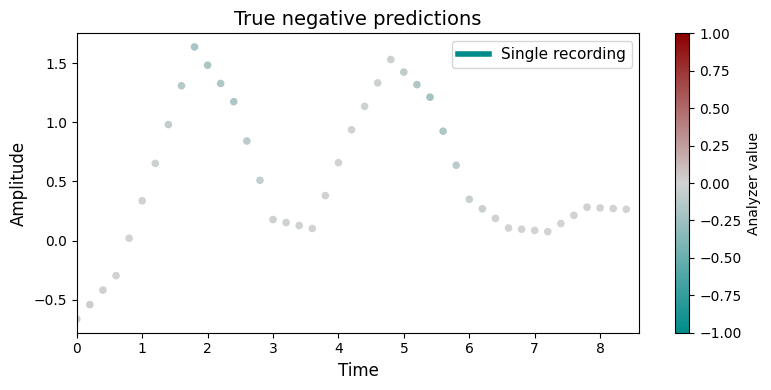

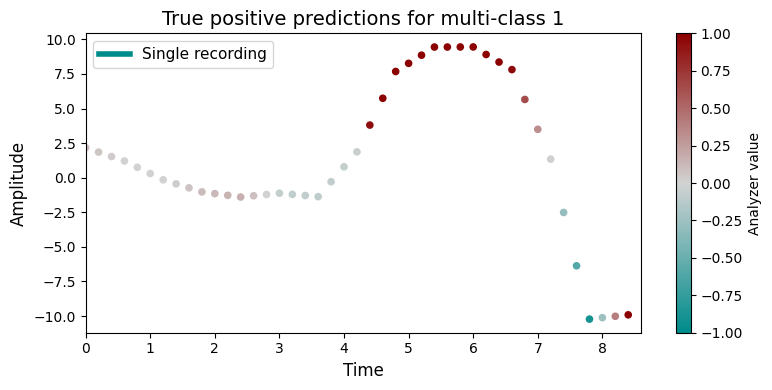

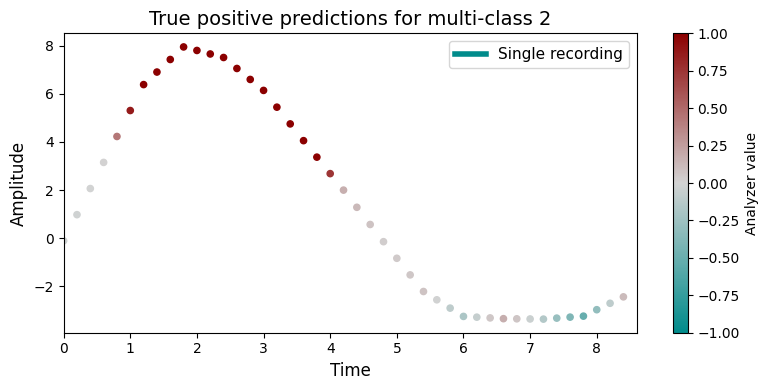

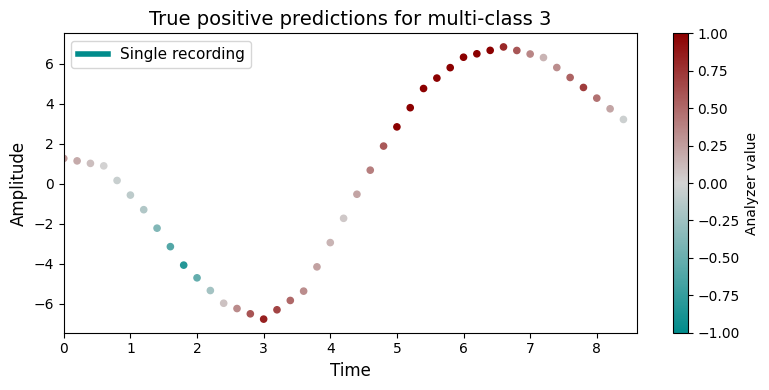

In [30]:
create_comparison_plot(full_extractor_XAIProject, binary_class_num = 0, multiple_class_num=False, prediction_quality = "correct", random_ = True, average_sample = False, average_analyzer = False)
create_comparison_plot(full_extractor_XAIProject, binary_class_num = 1, multiple_class_num=1, prediction_quality = "correct", random_ = True, average_sample = False, average_analyzer = False)
create_comparison_plot(full_extractor_XAIProject, binary_class_num = 1, multiple_class_num=2, prediction_quality = "correct", random_ = True, average_sample = False, average_analyzer = False)
create_comparison_plot(full_extractor_XAIProject, binary_class_num = 1, multiple_class_num=3, prediction_quality = "correct", random_ = True, average_sample = False, average_analyzer = False)

C:\Users\darab\AppData\Local\Temp\ipykernel_25696\389779.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])
C:\Users\darab\AppData\Local\Temp\ipykernel_25696\389779.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])


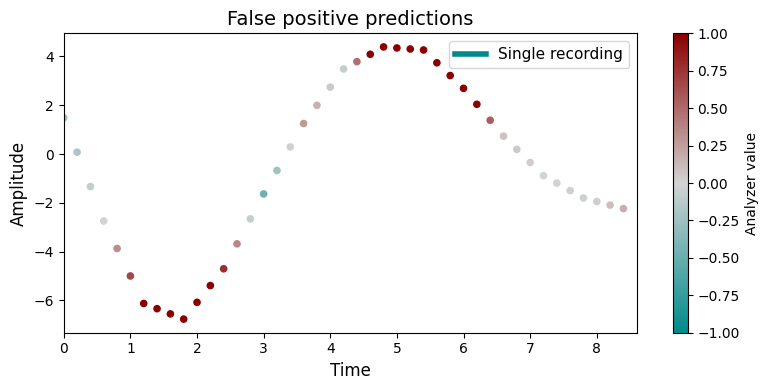

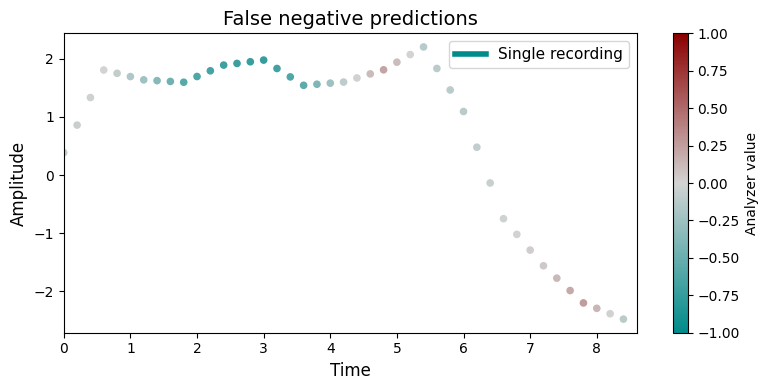

In [32]:
create_comparison_plot(full_extractor_XAIProject, binary_class_num = 1, multiple_class_num=False, prediction_quality = "false_positive", random_ = True, average_sample = False, average_analyzer = False)
create_comparison_plot(full_extractor_XAIProject, binary_class_num = 0, multiple_class_num=False, prediction_quality = "false_negative", random_ = True, average_sample = False, average_analyzer = False)

c:\Users\darab\anaconda3\envs\microneurography\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\darab\anaconda3\envs\microneurography\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\darab\AppData\Local\Temp\ipykernel_25696\389779.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])


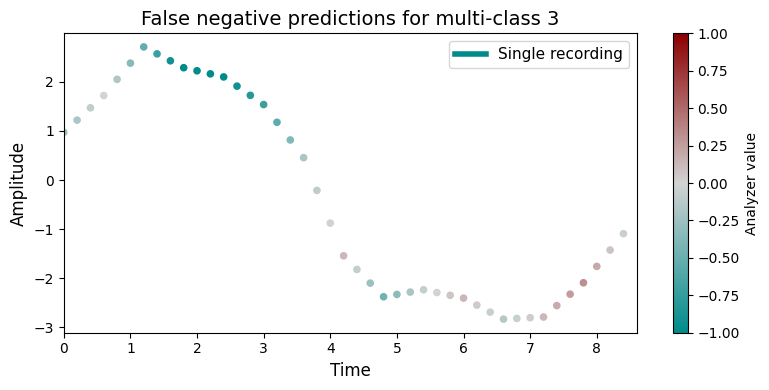

In [33]:
create_comparison_plot(full_extractor_XAIProject, binary_class_num = 1, multiple_class_num=1, prediction_quality = "false_negative", random_ = True, average_sample = False, average_analyzer = False)
create_comparison_plot(full_extractor_XAIProject, binary_class_num = 1, multiple_class_num=2, prediction_quality = "false_negative", random_ = True, average_sample = False, average_analyzer = False)
create_comparison_plot(full_extractor_XAIProject, binary_class_num = 1, multiple_class_num=3, prediction_quality = "false_negative", random_ = True, average_sample = False, average_analyzer = False)

In [ ]:
def create_comparison_plot_analyzer_avgs(project : XAIProject, prediction_quality):
    """
        plots the average relevance scores of the two class in one plot
    """

    if prediction_quality == "correct":
        indices_for_class_0 = np.intersect1d(same_indices, project.get_ture_neg_prediction_indices())
        indices_for_class_1 = np.intersect1d(same_indices, project.get_true_positive_indices_for_multiple_class(1))
        indices_for_class_2 = np.intersect1d(same_indices, project.get_true_positive_indices_for_multiple_class(2))
        indices_for_class_3 = np.intersect1d(same_indices, project.get_true_positive_indices_for_multiple_class(3))
        title = "Correct predictions"
    elif prediction_quality == "incorrect":
        indices_for_class_0 = np.intersect1d(same_indices, project.get_incorrect_prediction_indices_for_class(0))
        indices_for_class_1 = np.intersect1d(same_indices, project.get_incorrect_prediction_indices_for_class(1))
        title = "Incorrect predictions"
    elif prediction_quality == "false_negative":
        indices_for_class_0 = np.intersect1d(same_indices, project.get_false_negative_indices())
        indices_for_class_1 = np.intersect1d(same_indices, project.get_false_negative_indices_for_multiple_class(1))
        indices_for_class_2 = np.intersect1d(same_indices, project.get_false_negative_indices_for_multiple_class(2))
        indices_for_class_3 = np.intersect1d(same_indices, project.get_false_negative_indices_for_multiple_class(3))
        title = "False negative predictions"
    elif prediction_quality == "false_positive":
        #indices_for_class_0 = project.get_false_negative_indices()
        indices_for_class_1 = np.intersect1d(same_indices, project.get_false_positive_indices())
        title = "False positive predictions"

    if prediction_quality != "false_positive":
        input_for_class_0 = project.samples[indices_for_class_0]
        analyzer_for_class_0 = project.analyzer_output[indices_for_class_0]
        analyzer_class_mean_0 = np.mean(analyzer_for_class_0, axis=0, keepdims=True)
    input_for_class_1 = project.samples[indices_for_class_1]
    analyzer_for_class_1 = project.analyzer_output[indices_for_class_1]
    analyzer_class_mean_1 = np.mean(analyzer_for_class_1, axis=0, keepdims=True)
    if prediction_quality == "correct" or prediction_quality == "false_negative":
        input_for_class_2 = project.samples[indices_for_class_2]
        analyzer_for_class_2 = project.analyzer_output[indices_for_class_2]
        analyzer_class_mean_2 = np.mean(analyzer_for_class_2, axis=0, keepdims=True)
        input_for_class_3 = project.samples[indices_for_class_3]
        analyzer_for_class_3 = project.analyzer_output[indices_for_class_3]
        analyzer_class_mean_3 = np.mean(analyzer_for_class_3, axis=0, keepdims=True)

    fig = plt.figure(figsize=(8,4))

    ax = fig.add_subplot(111)
    if prediction_quality != "false_positive":
        data_class_0 = analyzer_class_mean_0[0, :]
    data_class_1 = analyzer_class_mean_1[0, :]
    if prediction_quality == "correct" or prediction_quality == "false_negative":
        data_class_2 = analyzer_class_mean_2[0, :]
        data_class_3 = analyzer_class_mean_3[0, :]



    if prediction_quality != "false_positive":

        ax.plot(data_class_0, label="Class 0", linewidth=3)

    ax.plot(data_class_1, label="Class 1", linewidth=3)
    if prediction_quality == "correct" or prediction_quality == "false_negative":

        ax.plot(data_class_2, label="Class 2", linewidth=3)
        ax.plot(data_class_3, label="Class 3", linewidth=3)
    ax.legend()
    ax.set_title(title + " - analyzer means")
    ax.set_ylabel("analyzer score")
    ax.set_xlabel("Time")
    #ax.set_xlim([0, len(y)])
    current_ticks = ax.get_xticks()
    adjusted_labels = current_ticks / 5
    ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])

C:\Users\darab\AppData\Local\Temp\ipykernel_25696\3232087533.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])
C:\Users\darab\AppData\Local\Temp\ipykernel_25696\3232087533.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])
C:\Users\darab\AppData\Local\Temp\ipykernel_25696\3232087533.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])
c:\Users\darab\anaconda3\envs\microneurography\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\darab\anaco

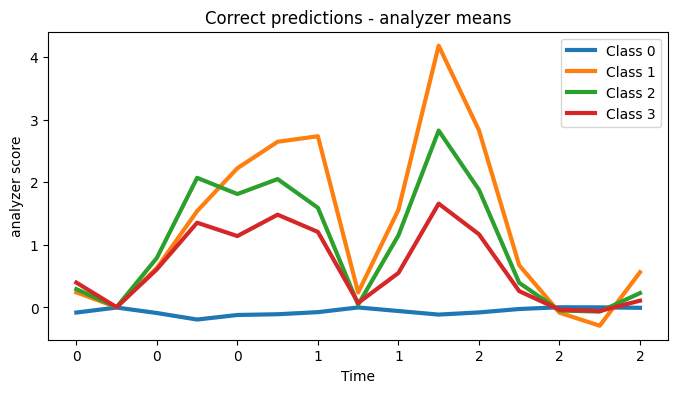

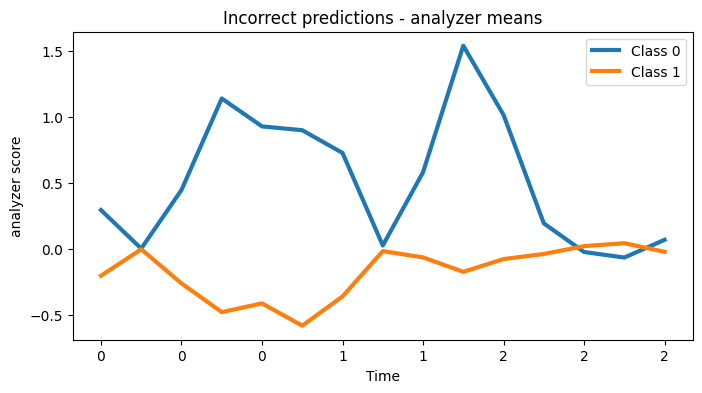

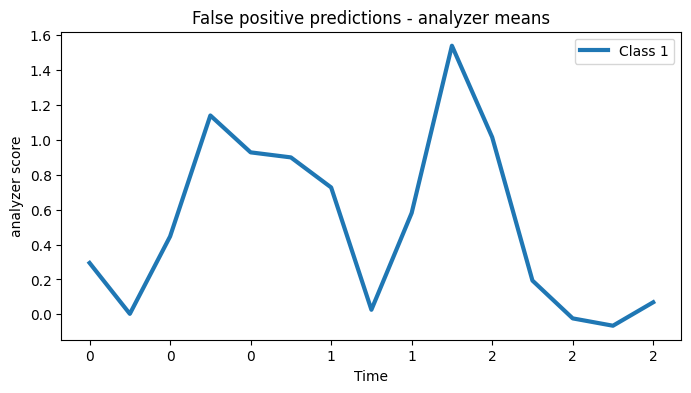

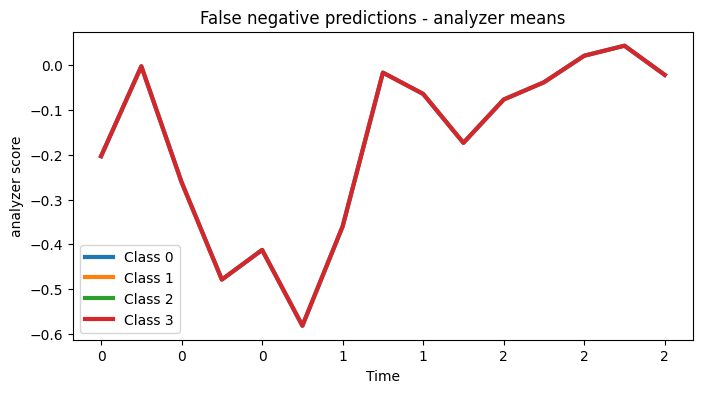

In [35]:
create_comparison_plot_analyzer_avgs(full_extractor_XAIProject, "correct")
create_comparison_plot_analyzer_avgs(full_extractor_XAIProject, "incorrect")
create_comparison_plot_analyzer_avgs(full_extractor_XAIProject, "false_positive")
create_comparison_plot_analyzer_avgs(full_extractor_XAIProject, "false_negative")

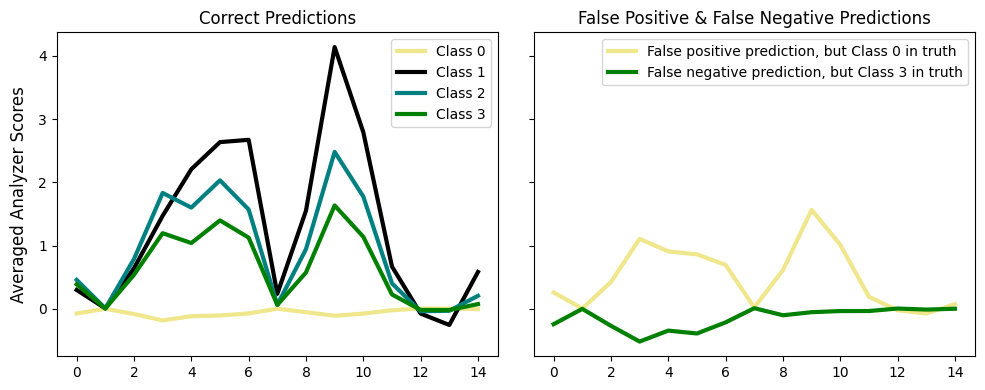

In [71]:
def create_comparison_plots_two_axes(project: XAIProject):
    """
    Creates two subplots for average relevance scores: one for correct predictions and one combining false positive
    and false negative predictions.
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    titles = ["Correct Predictions", "False Positive & False Negative Predictions"]

    # First subplot: Correct predictions
    indices_for_class_0 = np.intersect1d(same_indices, project.get_ture_neg_prediction_indices())
    indices_for_class_1 = np.intersect1d(same_indices, project.get_true_positive_indices_for_multiple_class(1))
    indices_for_class_2 = np.intersect1d(same_indices, project.get_true_positive_indices_for_multiple_class(2))
    indices_for_class_3 = np.intersect1d(same_indices, project.get_true_positive_indices_for_multiple_class(3))

    analyzer_for_class_0 = project.analyzer_output[indices_for_class_0]
    analyzer_for_class_1 = project.analyzer_output[indices_for_class_1]
    analyzer_for_class_2 = project.analyzer_output[indices_for_class_2]
    analyzer_for_class_3 = project.analyzer_output[indices_for_class_3]

    analyzer_class_mean_0 = np.mean(analyzer_for_class_0, axis=0, keepdims=True)
    analyzer_class_mean_1 = np.mean(analyzer_for_class_1, axis=0, keepdims=True)
    analyzer_class_mean_2 = np.mean(analyzer_for_class_2, axis=0, keepdims=True)
    analyzer_class_mean_3 = np.mean(analyzer_for_class_3, axis=0, keepdims=True)

    ax = axes[0]
    ax.plot(analyzer_class_mean_0[0, :], label="Class 0", linewidth=3, color="khaki")
    ax.plot(analyzer_class_mean_1[0, :], label="Class 1", linewidth=3, color="black")
    ax.plot(analyzer_class_mean_2[0, :], label="Class 2", linewidth=3, color="teal")
    ax.plot(analyzer_class_mean_3[0, :], label="Class 3", linewidth=3, color="green")
    ax.set_title(titles[0])
    #ax.set_xlabel("Time")
    ax.legend()

    # Second subplot: False positive and false negative predictions
    indices_for_false_positive = np.intersect1d(same_indices, project.get_false_positive_indices())
    indices_for_false_negative_0 = np.intersect1d(same_indices, project.get_false_negative_indices())
    indices_for_false_negative_1 = np.intersect1d(same_indices, project.get_false_negative_indices_for_multiple_class(1))
    indices_for_false_negative_2 = np.intersect1d(same_indices, project.get_false_negative_indices_for_multiple_class(2))
    indices_for_false_negative_3 = np.intersect1d(same_indices, project.get_false_negative_indices_for_multiple_class(3))

    analyzer_for_false_positive = project.analyzer_output[indices_for_false_positive]
    analyzer_for_false_negative_0 = project.analyzer_output[indices_for_false_negative_0]
    analyzer_for_false_negative_1 = project.analyzer_output[indices_for_false_negative_1]
    analyzer_for_false_negative_2 = project.analyzer_output[indices_for_false_negative_2]
    analyzer_for_false_negative_3 = project.analyzer_output[indices_for_false_negative_3]

    analyzer_mean_false_positive = np.mean(analyzer_for_false_positive, axis=0, keepdims=True)
    # analyzer_mean_false_negative_0 = np.mean(analyzer_for_false_negative_0, axis=0, keepdims=True)
    # analyzer_mean_false_negative_1 = np.mean(analyzer_for_false_negative_1, axis=0, keepdims=True)
    # analyzer_mean_false_negative_2 = np.mean(analyzer_for_false_negative_2, axis=0, keepdims=True)
    analyzer_mean_false_negative_3 = np.mean(analyzer_for_false_negative_3, axis=0, keepdims=True)

    ax = axes[1]
    ax.plot(analyzer_mean_false_positive[0, :], label="False positive prediction, but Class 0 in truth", linewidth=3, color="khaki")
    # ax.plot(analyzer_mean_false_negative_0[0, :], label="False Negative Class 0", linewidth=3)
    # ax.plot(analyzer_mean_false_negative_1[0, :], label="False Negative Class 1", linewidth=3)
    # ax.plot(analyzer_mean_false_negative_2[0, :], label="False Negative Class 2", linewidth=3)
    ax.plot(analyzer_mean_false_negative_3[0, :], label="False negative prediction, but Class 3 in truth", linewidth=3, color="green")
    ax.set_title(titles[1])
    # ax.set_xlabel("Time")
    ax.legend()

    # Shared y-label
    fig.supylabel("Averaged Analyzer Scores")
    plt.tight_layout()
    plt.show()

create_comparison_plots_two_axes(full_extractor_XAIProject)


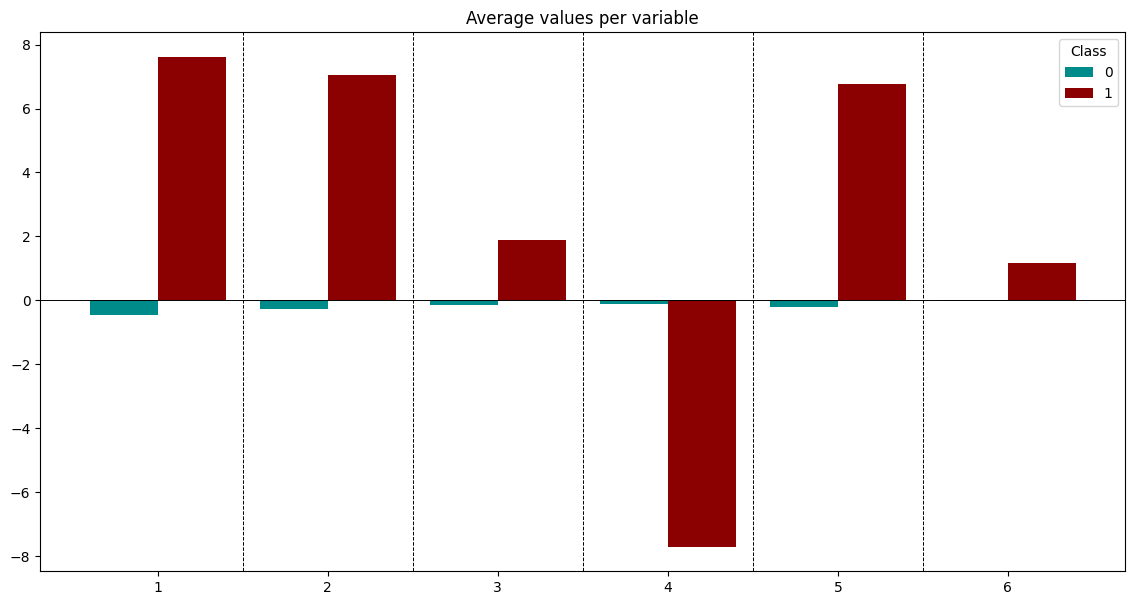

In [72]:
def plot_avg_variables(project : XAIProject, indices_0, indices_1):

    values_0 = project.analyzer_output[indices_0]
    values_1 = project.analyzer_output[indices_1]

    avg_values_0 = np.mean(values_0, axis=0)
    avg_values_1 = np.mean(values_1, axis=0)


    num_vars = len(avg_values_0)
    x = np.arange(num_vars)
    width = 0.4

    fig, ax = plt.subplots(figsize=(14, 7))
    blue = (0 / 255, 139 / 255, 139 / 255)
    red = (139 / 255, 0 / 255, 0 / 255)
    ax.bar(x - width / 2, avg_values_0, width=width, color=blue, label='0')

    ax.bar(x + width / 2, avg_values_1, width=width, color=red, label='1')

    for i in range(1, num_vars):
        ax.axvline(x=i - 0.5, color='black', linestyle='--', linewidth=0.7)

    ax.axhline(y=0, color='black', linewidth=0.7)

    ax.set_title("Average values per variable")
    ax.set_xticks(x)
    ax.set_xticklabels(np.arange(1, num_vars + 1))
    ax.legend(title='Class')

    plt.show()

indices_0 = np.intersect1d(np.where(feature_extractor_XAIProject.prediction_labels == 0)[0], np.where(feature_extractor_XAIProject.binary_labels == 0)[0])
indices_1 = np.intersect1d(np.where(feature_extractor_XAIProject.prediction_labels == 1)[0], np.where(feature_extractor_XAIProject.binary_labels == 1)[0])

indices_0 = np.intersect1d(same_indices, indices_0)
indices_1 = np.intersect1d(same_indices, indices_1)

plot_avg_variables(feature_extractor_XAIProject, indices_0, indices_1)

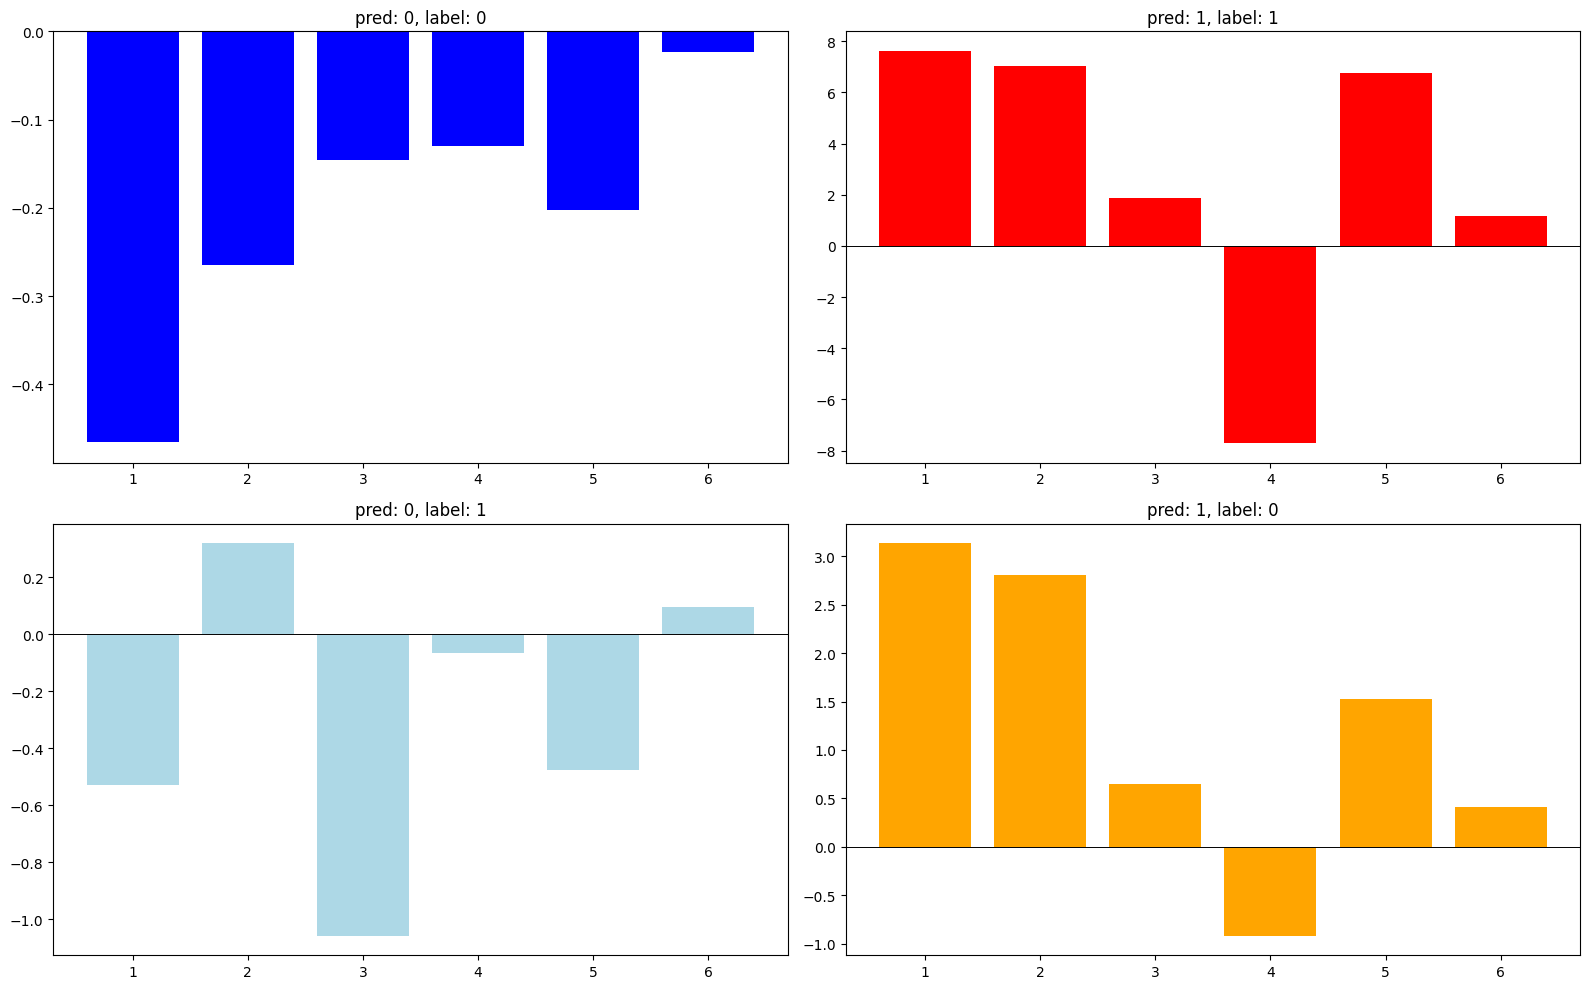

In [73]:

def plot_avg_variables_sep(project : XAIProject, ax, indices, title, color):
    values = project.analyzer_output[indices]
    avg_values = np.mean(values, axis=0)

    num_vars = len(avg_values)
    x = np.arange(num_vars)

    ax.bar(x, avg_values, color=color)

    ax.axhline(y=0, color='black', linewidth=0.7)

    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(np.arange(1, num_vars + 1))

indices_0 = np.intersect1d(np.where(feature_extractor_XAIProject.prediction_labels == 0)[0], np.where(feature_extractor_XAIProject.binary_labels == 0)[0])
indices_1 = np.intersect1d(np.where(feature_extractor_XAIProject.prediction_labels == 1)[0], np.where(feature_extractor_XAIProject.binary_labels == 1)[0])
indices_0_1 = np.intersect1d(np.where(feature_extractor_XAIProject.prediction_labels == 0)[0], np.where(feature_extractor_XAIProject.binary_labels == 1)[0])
indices_1_0 = np.intersect1d(np.where(feature_extractor_XAIProject.prediction_labels == 1)[0], np.where(feature_extractor_XAIProject.binary_labels == 0)[0])

fig, axs = plt.subplots(2, 2, figsize=(16, 10))

indices_0 = np.intersect1d(same_indices, indices_0)
indices_1 = np.intersect1d(same_indices, indices_1)
indices_0_1 = np.intersect1d(same_indices, indices_0_1)
indices_1_0 = np.intersect1d(same_indices, indices_1_0)

plot_avg_variables_sep(feature_extractor_XAIProject, axs[0, 0], indices_0, "pred: 0, label: 0", color='blue')
plot_avg_variables_sep(feature_extractor_XAIProject, axs[0, 1], indices_1, "pred: 1, label: 1", color='red')
plot_avg_variables_sep(feature_extractor_XAIProject, axs[1, 0], indices_0_1, "pred: 0, label: 1", color='lightblue')
plot_avg_variables_sep(feature_extractor_XAIProject, axs[1, 1], indices_1_0, "pred: 1, label: 0", color='orange')

plt.tight_layout()
plt.show()

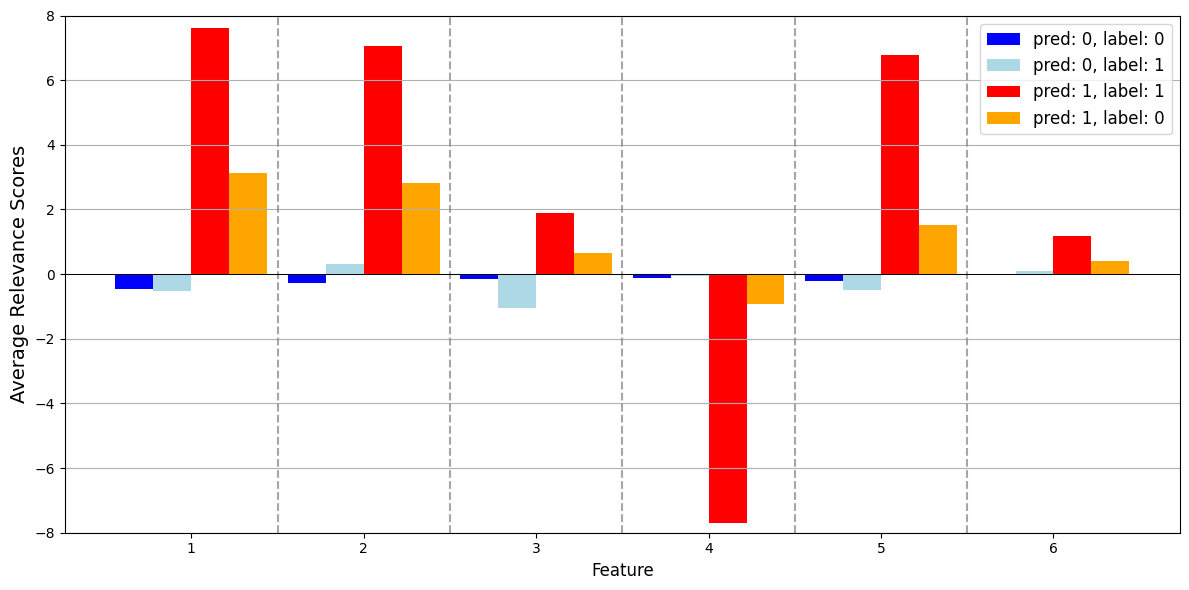

In [ ]:
def plot_avg_variables_combined(project: XAIProject, ax, indices_list, labels, colors):
    """
    Plots average variables with 4 bars for each variable at each x-axis position.
    
    Parameters:
        project: XAIProject instance containing analyzer_output.
        ax: The matplotlib Axes object to plot on.
        indices_list: List of index arrays for each group (e.g., [indices_0, indices_1, ...]).
        labels: List of labels for each group (e.g., ["pred: 0, label: 0", ...]).
        colors: List of colors for each group (e.g., ["blue", "red", ...]).
    """
    avg_values_list = [np.mean(project.analyzer_output[indices], axis=0) for indices in indices_list]
    num_vars = len(avg_values_list[0])
    x = np.arange(num_vars)

    bar_width = 0.22
    offsets = [-1.5, -0.5, 0.5, 1.5]

    for avg_values, label, color, offset in zip(avg_values_list, labels, colors, offsets):
        ax.bar(x + offset * bar_width, avg_values, width=bar_width, label=label, color=color)

    ax.set_ylim(-8, 8)
    for i in range(1, num_vars):
        ax.vlines(x=i - 0.5, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='gray', linestyle='--', alpha=0.7)

    ax.axhline(y=0, color='black', linewidth=0.7)
    #ax.set_title("Average Relevance Scores for Features after VPLayer")
    ax.set_xticks(x)
    ax.set_xticklabels(np.arange(1, num_vars + 1))
    ax.set_xlabel("Feature",fontsize = 12)
    ax.set_ylabel("Average Relevance Scores",fontsize = 14)
    ax.legend(fontsize = 12)

indices_0 = np.intersect1d(same_indices, np.intersect1d(
    np.where(feature_extractor_XAIProject.prediction_labels == 0)[0],
    np.where(feature_extractor_XAIProject.binary_labels == 0)[0]
))
indices_1 = np.intersect1d(same_indices, np.intersect1d(
    np.where(feature_extractor_XAIProject.prediction_labels == 1)[0],
    np.where(feature_extractor_XAIProject.binary_labels == 1)[0]
))
indices_0_1 = np.intersect1d(same_indices, np.intersect1d(
    np.where(feature_extractor_XAIProject.prediction_labels == 0)[0],
    np.where(feature_extractor_XAIProject.binary_labels == 1)[0]
))
indices_1_0 = np.intersect1d(same_indices, np.intersect1d(
    np.where(feature_extractor_XAIProject.prediction_labels == 1)[0],
    np.where(feature_extractor_XAIProject.binary_labels == 0)[0]
))


indices_list = [indices_0, indices_0_1, indices_1, indices_1_0]
labels = ["pred: 0, label: 0", "pred: 0, label: 1", "pred: 1, label: 1", "pred: 1, label: 0"]
colors = ["blue", "lightblue", "red", "orange"]


fig, ax = plt.subplots(figsize=(12, 6))
plot_avg_variables_combined(feature_extractor_XAIProject, ax, indices_list, labels, colors)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


In [130]:
feature_extractor_XAIProject.analyzer_output.shape

(403574, 6)